<a href="https://colab.research.google.com/github/Nickeniklas/smart-charge-ga/blob/main/genetic-algorithm-ev-charging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Optimization

Hourly energy price data

→ optimized using a **meta-heuristic**

→ optimized using a **deterministic technique.**

### Setup:
1. Import and preprocess data
2. Define problem
3. Create optimization algorithms
4. Analysis

# 1. Import and preprocess data


Contains data for more than 10 weeks, for many countries.

We will only need one:
- One Country.
- ~10 weeks.

In [1]:
# all import modules
import random
import math
import matplotlib.pyplot as plt
import itertools
import numpy as np
import kagglehub
import pandas as pd


In [2]:
path = kagglehub.dataset_download("henriupton/electricity-dayahead-prices-entsoe")

100%|██████████| 160k/160k [00:00<00:00, 13.2MB/s]

Extracting files...


In [3]:
# data as pandas dataframe
df = pd.read_csv(path + "/electricity_dah_prices.csv")
df.head()

,date,hour,france,italy,belgium,spain,uk,germany
0,2022/01/01,00:00 - 01:00,89.06,170.28,82.02,145.86,0.27,50.05
1,2022/01/01,01:00 - 02:00,78.48,155.72,67.07,114.90,-0.01,41.33
2,2022/01/01,02:00 - 03:00,85.16,147.09,75.11,113.87,0.27,43.22
3,2022/01/01,03:00 - 04:00,50.00,91.00,50.91,97.80,-0.01,45.46
4,2022/01/01,04:00 - 05:00,37.67,104.00,37.67,97.80,-0.01,37.67


In [4]:
len(df['date'])

8761

In [5]:
# select wanted columns (germany only)
df = df[['date', 'hour', 'germany']]
#rename colum "germany" to just "price"
df = df.rename(columns={'germany': 'price'})
df.head(3)

,date,hour,price
0,2022/01/01,00:00 - 01:00,50.05
1,2022/01/01,01:00 - 02:00,41.33
2,2022/01/01,02:00 - 03:00,43.22


In [6]:
# Convert EUR/MWh to cents/kWh
df['price'] = df['price'] / 10.0

In [7]:
# Select roughly 10 weeks, from 2022 january to march
df = df[:1680]

In [8]:
df.tail(3)

,date,hour,price
1677,2022/03/11,21:00 - 22:00,6.977
1678,2022/03/11,22:00 - 23:00,8.105
1679,2022/03/11,23:00 - 00:00,6.727


In [9]:
# check for nan values
df.isna().sum()

,0
date,0
hour,0
price,0


In [10]:
 # set date as pandas datetime
df['date'] = pd.to_datetime(df['date'])

In [11]:
# ensure price is float not string
type(df['price'][1])

numpy.float64

In [12]:
# print highest and lowest price
print(df['price'].max())
print(df['price'].min())

70.0
-0.10500000000000001


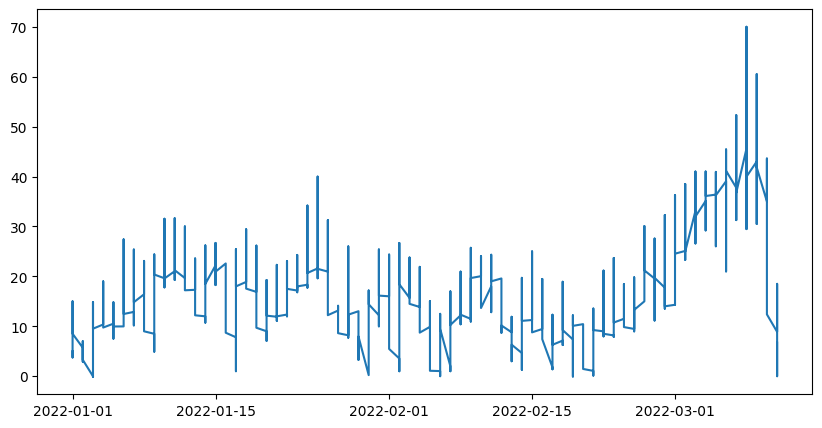

In [13]:
# basic plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(df['date'], df['price'])
plt.show()

# 2. Define Optimization Problem

**High level explanation:**
- We want our EV to charge each night to full.
- During each day we need X amount of kWh.
- Our Cables can not take all X in one hour, they are rated for Y Kw per hour.
- Car should be charged in the morning, to add stochasticity we dont know when exactly we leave each morning (range between ex. 3-9am).

**Objective:**
- Minimize cost of EV charger

**Constraints:**
- Charger capability
- Charger capacity
- Car leaves between 3-9am



# 3. Create Optimization Algorithms

## Meta-Heuristic

**Genetic Algorithm:**
1. Generate schedules
2. Get fitness
3. Select parents
4. Crossover
5. Mutate
6. Repair
7. Select next generation

### 1. Generate schedules

array of values between 0-7 for each hour

In [14]:
# array of charging power values
def generate_schedule(max_charge_power, full_charge, amount):
  """
  Generate random schedule of charging.
  Parameters:
    max_charge_power = how much cables can take in one hour (kw).
    full_charge = target charge amount (kWh).
    amount = how many schedules to generate.
  """
  schedules = []
  for _ in range(amount):
    # Generate random schedule
    # 1. Generate random numbers that sum to 1.0
    random_weights = np.random.dirichlet(np.ones(24)) # 24h in a day
    # 2. Scale them to sum to 40
    schedule = random_weights * full_charge
    # 3. Repair: Clip to 0 and 7
    schedule = np.clip(schedule, 0, max_charge_power)
    schedules.append(schedule)
  return schedules

In [15]:
# create schedule
schedule = generate_schedule(7, 30, 1)
print("Schedules:", schedule)


Schedules: [array([1.49717948, 0.66845372, 2.48346784, 1.78076407, 0.19671728,
       2.09981467, 0.04650363, 0.2462739 , 2.14364974, 0.02999152,
       1.55327842, 2.5393381 , 0.23067424, 0.25091652, 1.08825474,
       1.5317135 , 1.00476884, 0.34401503, 1.45337111, 2.47406219,
       0.85231224, 0.78415285, 1.47068205, 3.22964431])]


### 2. Get fitness


In [16]:
def get_fitness(schedule, prices, needed_to_fill):
    """
    Evaluate score and possible penalty for charging schedule.
    Parameters:
      schedule = how much charge on each hour.
      prices = prices for the day.
      needed_to_fill = needed for full charge.
    """
    # flatten np arrays
    schedule = np.asarray(schedule).ravel()
    prices = np.asarray(prices).ravel()
    # Pre-calculate cumulative charge and cost for the whole day
    cum_charge = np.cumsum(schedule)
    cum_cost = np.cumsum(schedule * prices)

    # Generate 100 departure indices at once
    departures = np.random.normal(loc=8, scale=0.5, size=100)
    indices = np.clip(departures.astype(int), 0, 23)

    # Grab the values for all 100 scenarios at once (no loop!)
    charges_at_departure = cum_charge[indices]
    costs_at_departure = cum_cost[indices]

    # Calculate penalties vectorized
    penalties = np.where(charges_at_departure < needed_to_fill,
                         (needed_to_fill - charges_at_departure)**2 * 5.0, 0)

    return np.mean(costs_at_departure + penalties)

In [17]:
# Select the top 2 solutions as parents
def select_parents(schedules, today_prices, needed_to_fill):
    """
    Select best individuals out of population.
    Parameters:
      schedules = array of schedules.
      today_prices = prices for the day.
      needed_to_fill = needed for full charge.
    """
    # sort by fitness (rank children)
    schedules.sort(key=lambda x: get_fitness(x, today_prices, needed_to_fill))
    # top schedules
    return schedules[0], schedules[1]

In [18]:
def crossover(parent1, parent2):
    """
    Combine parents at a random point.
    Parameters:
      parent1 = array of 24 values, representing charging power for each hour.
      parent2 = array of 24 values, representing charging power for each hour.
    """
    # Pick any hour from 1 to 23 as the swap point
    crossover_point = np.random.randint(1, len(parent1))

    # Create the child
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

In [19]:
# swap 2 numbers in row with a mutation rate (%) chance
def mutate(child, max_power, mutation_rate=0.1):
    # Only mutate based on the probability rate
    if np.random.rand() > mutation_rate:
        return child

    # Pick two random hours
    hour_a, hour_b = np.random.choice(range(24), size=2, replace=False)

    # Move a random 'nudge' of energy
    nudge = np.random.uniform(0, 2.0)

    # Take from A, give to B
    child[hour_a] -= nudge
    child[hour_b] += nudge

    # Use your repair logic to keep it within 0 and max_power
    child = np.clip(child, 0, max_power)

    return child

In [20]:
# Repair the child if it is infeasible
def repair(schedule, max_charge_power, needed_to_fill):
    """
    Adjusts a 24-hour schedule to meet constraints.
    Parameters:
      schedule: array of 24 values, representing charging power for each hour.
      max_power: Charging capability in one hour.
      needed_to_fill: the amount we need to fill.
    """
    # 1. Ensure no negative charging
    schedule = np.maximum(schedule, 0)

    # 2. Cap at max hardware power (7kW)
    schedule = np.minimum(schedule, max_charge_power)

    # 3. Scale to meet the energy target
    current_total = np.sum(schedule)

    # THE MASK: Car is gone from 9 AM (index 9) to 5 PM (index 17)
    # We set these hours to 0 before we do the scaling/redistribution
    schedule[9:18] = 0

    if current_total > 0:
        # Multiply every hour by the ratio needed to hit the target
        schedule = schedule * (needed_to_fill / current_total)
    else:
        # If schedule is all zeros, just fill the first 4 hours as a fallback
        schedule[:4] = needed_to_fill / 4

    # 4. Final safety check: Scaling might have pushed some hours above max_power
    schedule = np.minimum(schedule, needed_to_fill)
    return schedule


In [21]:
# combine all solutions (parents + children) and keep top population
def select_next_generation(population, children, prices, target_charge):
    # get scores for schedules
    population_scores = [get_fitness(schedule, prices, target_charge) for schedule in population]
    children_scores = [get_fitness(schedule, prices, target_charge) for schedule in children]
    # combine with children
    all_scores = population_scores + children_scores
    new_population = population + children
    # sort by lowest first
    sorted_idx = np.argsort(all_scores)
    # return sorted list of population
    return [new_population[sorted_idx[i]] for i in range(len(population))]

In [22]:
def run_ga(prices, max_charge_power, full_charge, total_days):
  ga_daily_costs = []
  greedy_daily_costs = []
  current_soc = 0.0

  # Generate 40 random schedules (inital population)
  population = generate_schedule(max_charge_power, full_charge, 40) # outside day loop for warm starts

  # -- OPTIMIZATION --
  # loop through each day
  for day in range(total_days):
      # Get the prices for THIS specific 24-hour period
      start_idx = day * 24
      end_idx = start_idx + 24
      today_prices = prices[start_idx:end_idx]

      # How much we need to refill each night
      needed_to_fill = full_charge - current_soc

      stall_counter = 0 # for generations

      # generations loop
      for generation in range(30):
          children = []
          # create children that amount to half the population
          for _ in range(len(population) // 2):
              # Select parents
              parent1, parent2 = select_parents(population, today_prices, needed_to_fill)
              # Crossover
              child = crossover(parent1, parent2)
              # Mutate
              child = mutate(child, max_charge_power, mutation_rate=0.1)
              # Repair
              child = repair(child, max_charge_power, needed_to_fill)
              # append to list of children
              children.append(child)

          # get scores
          population_scores = [get_fitness(schedule, today_prices, needed_to_fill) for schedule in population]
          children_scores = [get_fitness(schedule, today_prices, needed_to_fill) for schedule in children]
          # sort scores, best (index 0)
          best_pop_score = np.min(population_scores)
          best_child_score = np.min(children_scores)

          # Check for improvement
          if best_child_score < (best_pop_score - 0.001):
              stall_counter = 0 # Reset! We found a better deal
          else:
              stall_counter += 1 # No progress this time

          # STOP SIGN: We haven't improved in 15 tries
          if stall_counter >= 5:
              break
          # update population for next generation
          population = select_next_generation(population, children, today_prices, needed_to_fill)

      # -- End of night(charging done) --
      best_schedule = population[0]
      # Calculate what actually happened (Charge until 8am)
      actual_gain = np.sum(best_schedule[:8])
      ga_cost_today = np.sum(best_schedule * today_prices)

      # 1. State at 8 AM (Full or nearly full)
      soc_at_departure = current_soc + actual_gain

      # Update SoC next day driving: (Current + Gain - 30kWh drive)
      current_soc = current_soc + actual_gain - 30.0
      current_soc = np.clip(current_soc, 0, 40) # Keep battery in bounds

      ga_daily_costs.append(ga_cost_today)
      print(f"Day {day}: GA Cost={ga_cost_today:.2f} | Charged to {soc_at_departure} | Battery after Day={current_soc:.2f}kWh")

  ga_total = sum(ga_daily_costs) / 100 # convert to Euro
  print(f"GA Total {total_days} days cost: {ga_total:.2f}€")
  return ga_daily_costs

In [23]:
# Run GA on 10 weeks of electricity prices
# setup
prices = df['price']
max_charge_power = 7 #kW
full_charge = 40 #kWh
total_days = 70 # 70 = 10 weeks

final_costs = run_ga(prices, max_charge_power, full_charge, total_days)

Day 0: GA Cost=180.69 | Charged to 37.5894012661321 | Battery after Day=7.59kWh
Day 1: GA Cost=128.83 | Charged to 37.966110443050766 | Battery after Day=7.97kWh
Day 2: GA Cost=44.03 | Charged to 38.35823111889532 | Battery after Day=8.36kWh
Day 3: GA Cost=364.68 | Charged to 39.0278496891127 | Battery after Day=9.03kWh
Day 4: GA Cost=271.67 | Charged to 39.244204995226355 | Battery after Day=9.24kWh
Day 5: GA Cost=387.28 | Charged to 38.792415409635026 | Battery after Day=8.79kWh
Day 6: GA Cost=353.41 | Charged to 38.887980935867745 | Battery after Day=8.89kWh
Day 7: GA Cost=486.62 | Charged to 38.656042576485206 | Battery after Day=8.66kWh
Day 8: GA Cost=219.72 | Charged to 39.27008965229871 | Battery after Day=9.27kWh
Day 9: GA Cost=602.01 | Charged to 38.09850698587849 | Battery after Day=8.10kWh
Day 10: GA Cost=628.91 | Charged to 38.08891330864174 | Battery after Day=8.09kWh
Day 11: GA Cost=588.66 | Charged to 38.118350178983796 | Battery after Day=8.12kWh
Day 12: GA Cost=498.13 

# 4. Analysis

## Deterministic technique

**Simple Greedy**

Impossible in real life:
- Has no stochasticity
- Needs perfect foreinsight for prices

In [24]:
def solve_greedy(today_prices, needed_to_fill, max_charge_power):
    today_prices = np.asarray(today_prices)

    # 1. Charging hours
    valid_hours = list(range(0, 8)) + list(range(18, 24))# index map: [0,1,2,3,4,5,6,7, 18,19,20,21,22,23]

    # 2. Prices for those hours and sort them
    hour_price_pairs = [(h, today_prices[h]) for h in valid_hours]
    hour_price_pairs.sort(key=lambda x: x[1]) # Sort by price

    greedy_schedule = np.zeros(24)
    remaining_energy = needed_to_fill

    # 3. Fill cheapest hours first
    for hour, price in hour_price_pairs:
        if remaining_energy <= 0: break

        charge = min(remaining_energy, max_charge_power)
        greedy_schedule[hour] = charge
        remaining_energy -= charge

    greedy_cost = np.sum(greedy_schedule * today_prices)

    return greedy_cost, greedy_schedule

### Expanded version of GA run
- greedy added to the daily loop
- Better prints, with analysis

In [25]:
def run_ga_greedy_analysis(prices, max_charge_power, full_charge, total_days):
  ga_daily_costs = []
  ga_efficiency_scores = []
  greedy_daily_costs = []
  current_soc = 0.0

  # Generate 40 random schedules (inital population)
  population = generate_schedule(max_charge_power, full_charge, 40) # outside day loop for warm starts

  # -- OPTIMIZATION --
  # loop through each day
  for day in range(total_days):
      # Get the prices for THIS specific 24-hour period
      start_idx = day * 24
      end_idx = start_idx + 24
      today_prices = prices[start_idx:end_idx]

      # How much we need to refill each night
      needed_to_fill = full_charge - current_soc

      stall_counter = 0 # for generations

      # generations loop
      for generation in range(30):
          children = []
          # create children that amount to half the population
          for _ in range(len(population) // 2):
              # Select parents
              parent1, parent2 = select_parents(population, today_prices, needed_to_fill)
              # Crossover
              child = crossover(parent1, parent2)
              # Mutate
              child = mutate(child, max_charge_power, mutation_rate=0.1)
              # Repair
              child = repair(child, max_charge_power, needed_to_fill)
              # append to list of children
              children.append(child)

          # get scores
          population_scores = [get_fitness(schedule, today_prices, needed_to_fill) for schedule in population]
          children_scores = [get_fitness(schedule, today_prices, needed_to_fill) for schedule in children]
          # sort scores, best (index 0)
          best_pop_score = np.min(population_scores)
          best_child_score = np.min(children_scores)

          # Check for improvement
          if best_child_score < (best_pop_score - 0.001):
              stall_counter = 0 # Reset! We found a better deal
          else:
              stall_counter += 1 # No progress this time

          # STOP SIGN: We haven't improved in 15 tries
          if stall_counter >= 5:
              break
          # update population for next generation
          population = select_next_generation(population, children, today_prices, needed_to_fill)

      # -- End of night(charging done) --
      best_schedule = population[0]
      # Calculate what actually happened (Charge until 8am)
      actual_gain = np.sum(best_schedule[:8])
      ga_cost_today = np.sum(best_schedule * today_prices)

      # 1. State at 8 AM (Full or nearly full)
      soc_at_departure = current_soc + actual_gain

      # Update SoC next day driving: (Current + Gain - 30kWh drive)
      current_soc = current_soc + actual_gain - 30.0
      current_soc = np.clip(current_soc, 0, 40) # Keep battery in bounds

      ga_daily_costs.append(ga_cost_today)
      #print(f"Day {day}: GA Cost={ga_cost_today:.2f} | Charged to {soc_at_departure} | Battery after Day={current_soc:.2f}kWh")

      # --- GREEDY COMPARISON HERE ---
      greedy_cost_today, _ = solve_greedy(today_prices, needed_to_fill, max_charge_power)
      greedy_daily_costs += [greedy_cost_today]
      # Calculate Efficiency (%)
      # 100% means the GA was as good as the perfect greedy solution
      ga_efficiency = (greedy_cost_today / ga_cost_today) * 100
      ga_efficiency_scores.append(ga_efficiency)

      print(f"Day {day}: GA Cost: {ga_cost_today:.2f} | Greedy Cost: {greedy_cost_today:.2f} | Score: {ga_efficiency:.1f}%")

  print(f"Total {total_days} days cost: GA {sum(ga_daily_costs):.2f} | Greedy {sum(greedy_daily_costs):.2f} ")
  return ga_daily_costs, greedy_daily_costs, ga_efficiency_scores

In [26]:
# setup
prices = df['price']
max_charge_power = 7 #kW
full_charge = 40 #kWh
total_days = 70 # 70 = 10 weeks

ga_costs, _, ga_efficiency_scores = run_ga_greedy_analysis(prices, max_charge_power, full_charge, total_days)

total_ga_cost = sum(ga_costs)
# Assuming a 'dumb' average of 40 cents/kWh for 2022 peak hours
total_dumb_cost = total_days * 30 * 40

savings = (total_dumb_cost - total_ga_cost) / 100 # Convert cents to Euros

print(f"\n--- {total_days} DAYS FINAL REPORT ---")
print(f"Total Money Saved: €{savings:.2f}")
print(f"Avg. Efficiency vs. Perfect Greedy: {np.mean(ga_efficiency_scores):.1f}%")
print(f"Total Energy Delivered: {total_days * 30} kWh")

Day 0: GA Cost: 191.53 | Greedy Cost: 163.39 | Score: 85.3%
Day 1: GA Cost: 171.32 | Greedy Cost: 112.76 | Score: 65.8%
Day 2: GA Cost: 126.36 | Greedy Cost: -1.44 | Score: -1.1%
Day 3: GA Cost: 323.55 | Greedy Cost: 259.58 | Score: 80.2%
Day 4: GA Cost: 290.31 | Greedy Cost: 272.35 | Score: 93.8%
Day 5: GA Cost: 400.16 | Greedy Cost: 331.39 | Score: 82.8%
Day 6: GA Cost: 380.22 | Greedy Cost: 342.38 | Score: 90.0%
Day 7: GA Cost: 489.16 | Greedy Cost: 321.68 | Score: 65.8%
Day 8: GA Cost: 224.94 | Greedy Cost: 189.79 | Score: 84.4%
Day 9: GA Cost: 601.10 | Greedy Cost: 583.82 | Score: 97.1%
Day 10: GA Cost: 649.70 | Greedy Cost: 630.97 | Score: 97.1%
Day 11: GA Cost: 593.18 | Greedy Cost: 575.01 | Score: 96.9%
Day 12: GA Cost: 500.94 | Greedy Cost: 465.32 | Score: 92.9%
Day 13: GA Cost: 384.00 | Greedy Cost: 349.86 | Score: 91.1%
Day 14: GA Cost: 607.10 | Greedy Cost: 596.31 | Score: 98.2%
Day 15: GA Cost: 535.08 | Greedy Cost: 295.68 | Score: 55.3%
Day 16: GA Cost: 114.70 | Greedy Co

**During the peak of European crisis.** 81% efficiency on average, compared to perfect greedy. Definitely good result. Most days the score is over 90%, there are some days that with a perfect greedy, you could get a negative cost, which lead to a lower %.

    Avg. Efficiency vs. Perfect Greedy: 81.0%

**Total money saved** is GA compared to a fixed hardcoded rate.
```
# Assuming a 'dumb' average of 40 cents/kWh for 2022 peak hours
total_dumb_cost = total_days * 30 * 40
```


# 5. Results and Summary

## Result

Genetic Algorithm works well to optimize the energy charging of an EV. 81% average efficieny compared to PERFECT greedy.

## GA Summary
Genetic algorithm is fun to play with, and really does work on many problems. There is a lot to consider though. I was also not prepared for the amount of things to take into account when doing any type of energy optimization. I chose EV charging, since it sounded like an easy example, but there is infact a lot to think about.

### Things to consider in my EV charging optmization with Genetic Algorithm:
- **We do not have a static time when charging should be done:** Fitness functions simulates random departure times, with a normal distrubution around 8 am. This makes the problem stochastic.
- **Day by day with warm starts:** Previous best parents are used as "warm start" to make the loop faster and more efficent. Best practice is to have a mix of both; completely fresh and the best combined.
- **When is it good enough:** Since the fitness can never be 0, we need to determine ourselves some limit to when the solutions are good enough. My version checks if five generations in a row does not have a child that has better score than previous best.
- **Not charging from 9-17**. Car is probably away and energy is usually most expensive. So not charging between 9-17 is controlled inside the repair function.
- **Mutation swaps:** Instead of random mutations, we swap parts of values between hours. This keeps the total target the same, and should be more effective at finding cheaper hours.
- **How much does the car drive per day:** How much kWh is spent each day, currently hardcoded to -30kWh/day.
- **Peak of European energy crisis:** Current run is using data from the start of 2022, which was exactly when energy prices could vary from 50-500 in hours.
